In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/CS498DL/CS498DL-project/cases")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define neural network

In [ ]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, nof=50, dim=2, num_layers=4):
        super().__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, nof)
        def f():
          return nn.Sequential(nn.Linear(nof, nof), nn.Tanh())
        self.hidden_layer = nn.Sequential(
            *[f() for _ in range(num_layers)],
        )
        self.output_layer = nn.Linear(nof, 1)


    def forward(self, x, y):
        input = torch.cat((x, y), dim=-1)
        input = torch.tanh(self.input_layer(input))
        input = self.hidden_layer(input)
        input = self.output_layer(input)
        return input

# Initialize data and forcing function

torch.Size([100, 100, 1])


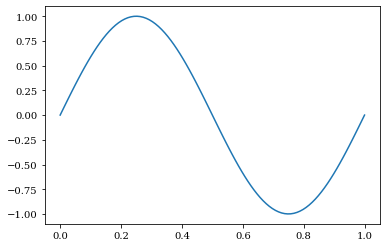

In [ ]:
# Initialize data
gridsize_x = 100
gridsize_y = 100
x = torch.linspace(0, 1, gridsize_x, device=device)
y = torch.linspace(0, 1, gridsize_y, device=device)
X, Y = torch.meshgrid(x, y)
X = X.to(device)
Y = Y.to(device)
num_modes = 3
# coef = np.random.rand(num_modes) * 10
coef = np.array([10.0, 1.0, 5.0])
f = torch.zeros_like(X)
for i in range(num_modes):
    f += coef[i] * torch.sin((i+1) * np.pi * X) * torch.sin((i+4) * np.pi * Y)

# load f data into torch
X = X.reshape((gridsize_x, gridsize_y, 1))
Y = Y.reshape((gridsize_x, gridsize_y, 1))
f = f.reshape((gridsize_x, gridsize_y, 1)).to(device)
Xc = X.clone().to(device)
Xc.requires_grad = True
Yc = Y.clone().to(device)
Yc.requires_grad = True

# load BC data into torch
bound_left = 0.0
bound_right = 0.0
u0 = torch.sin(2.0 * np.pi * y)

pe = 100

def plot(*args):
  return map(lambda x : x.cpu().detach().numpy(), args)

plt.plot(*plot(y, u0))

# Loss functions for different pdes

In [ ]:
# loss functions
def pde_loss_poisson(pred, x, y, pe, lambda_pde):
    du_dx = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
    du2_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    du_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0]
    du2_dy2 = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    loss = torch.sum(torch.square(du_dx + pred * du_dy - du2_dy2 / pe))
    return lambda_pde * loss / (gridsize_x * gridsize_y)

def boundary_loss_dirichlet(pred, bound_left, bound_right, u0, lambda_bound=1.0):
    loss = torch.sum((pred[:, 0, 0] - bound_left) ** 2 / gridsize_x + (pred[:, -1, 0] - bound_right) ** 2 / gridsize_x)
    loss += torch.sum((pred[0, :, 0] - u0) ** 2 / gridsize_y)
    return lambda_bound * loss

In [ ]:
# define network
net = Net(nof=50, num_layers=4).to(device)

# define optimizer
learning_rate = 0.0025
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Epoch 0 --- Loss : 2.501718759536743, pde_loss : 0.0004100824298802763, bound_loss : 2.5013086795806885
Epoch 1000 --- Loss : 0.00843026116490364, pde_loss : 0.005892418324947357, bound_loss : 0.002537843305617571
Epoch 2000 --- Loss : 0.001694048405624926, pde_loss : 0.001479910220950842, bound_loss : 0.00021413815557025373
Epoch 3000 --- Loss : 0.0005822083912789822, pde_loss : 0.0005376195767894387, bound_loss : 4.45887962996494e-05
Epoch 4000 --- Loss : 0.0004450091510079801, pde_loss : 0.00038310507079586387, bound_loss : 6.190408021211624e-05
Epoch 5000 --- Loss : 0.007751069031655788, pde_loss : 0.0052605061791837215, bound_loss : 0.002490562852472067
Epoch 6000 --- Loss : 0.0003820785495918244, pde_loss : 0.0002088351611746475, bound_loss : 0.0001732433884171769
Epoch 7000 --- Loss : 0.00021448427287396044, pde_loss : 0.00017456538625992835, bound_loss : 3.991888661403209e-05
Epoch 8000 --- Loss : 0.00026293788687326014, pde_loss : 0.0001935763721121475, bound_loss : 6.93615147

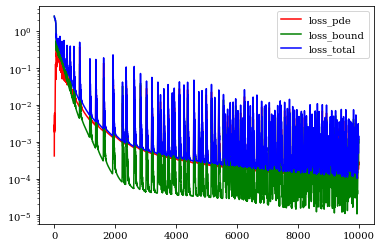

In [ ]:
# train
num_epochs = 10000
lambda_pde = 1.0
lambda_bound = 5.0
log = {"loss_pde" : [],
       "loss_bound" : [],
       "loss_total" : []}
for epoch in range(num_epochs):
    if epoch % 1000 == 0:
        learning_rate *= 0.99

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    net.train()

    upred = net.forward(Xc, Yc)

    loss_bound = boundary_loss_dirichlet(upred, bound_left, bound_right, u0, lambda_bound=lambda_bound)
    loss_pde = pde_loss_poisson(upred, Xc, Yc, pe, lambda_pde)
    loss = loss_pde + loss_bound
    log["loss_pde"].append(loss_pde.item())
    log["loss_bound"].append(loss_bound.item())
    log["loss_total"].append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} --- Loss : {loss}, pde_loss : {loss_pde}, bound_loss : {loss_bound}")

print(loss)
plt.semilogy(log["loss_pde"], 'r', label = 'loss_pde')
plt.semilogy(log["loss_bound"], 'g', label = 'loss_bound')
plt.semilogy(log["loss_total"], 'b', label = 'loss_total')
plt.legend()

In [ ]:
# Saving log file because colab doesnt have plotly shit
import pickle

with open('loss_burgers_shock.pickle', 'wb') as handle:
    pickle.dump(log, handle)

# Preview results

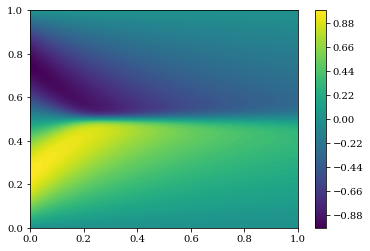

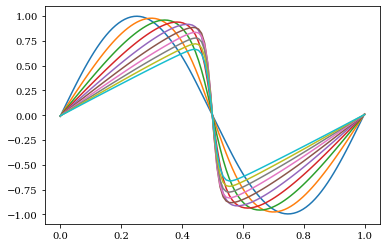

In [ ]:
pinn_sol = net.forward(X, Y)
plt.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), levels=100)
plt.colorbar()

freq = 5
plt.figure()
for i in range(10):
  plt.plot(*plot(y, pinn_sol[i * 5, :, 0]))

# Compute FDM solution for comparison

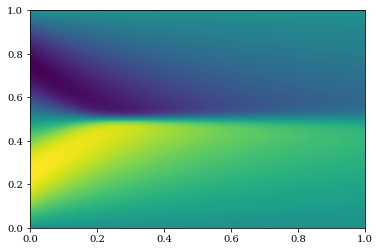

In [ ]:
def fdm_sol_stationary_viscous_burgers(u0, pe, final_time):
    """
    FDM solution for viscous burgers on domain [0, 1]
    assumes u = 0.0 at x = 0.0, 1.0
    """
    from scipy.sparse.linalg import spsolve
    import scipy.sparse as spp
    import numpy.linalg as la
    
    fdm_grid_size = u0.shape[0] - 2 # takes 2 end pts in account
    dx = 1.0 / (fdm_grid_size + 1) # takes 2 end pts in account
    gradient = (spp.diags([-0.5, 0.5], [-1, 1], shape=(fdm_grid_size, fdm_grid_size), 
                          format="csr") / dx)
    laplacian = (spp.diags([1.0, -2.0, 1.0], [-1, 0, 1],
                           shape=(fdm_grid_size, fdm_grid_size), format="csr") / (dx ** 2))

    fdm_sol = u0[1:-1].copy()
    time = 0.0
    while time < final_time:
        dt = 0.01 * dx
        if time + dt > final_time:
            dt = final_time - time
        fdm_sol[...] += dt * (-fdm_sol * (gradient @ fdm_sol) + laplacian * fdm_sol / pe)
        time += dt
    
    final_fdm_sol = np.zeros_like(u0)
    final_fdm_sol[1:-1] = fdm_sol
    return final_fdm_sol

import numpy as np
import matplotlib.pyplot as plt

pe = 100.0
fdm_grid_size = gridsize_y
x_fdm = np.linspace(0.0, 1.0, fdm_grid_size)
u0 = np.sin(2 * np.pi * x_fdm)
final_time = np.linspace(0.0, 0.5, 10)
# plt.plot(x_fdm, u0, '--')

fdm_sol = 0 * pinn_sol
final_time = np.linspace(0.0, 1.0, gridsize_x)
for i, t in enumerate(final_time):
    fdm_sol[i, ...] = torch.from_numpy(fdm_sol_stationary_viscous_burgers(u0, pe, t)).unsqueeze(-1)
    # plt.plot(x_fdm, fdm_sol)

plt.contourf(*plot(X[:, :, 0], Y[:, :, 0], fdm_sol[:, :, 0]), levels=100)

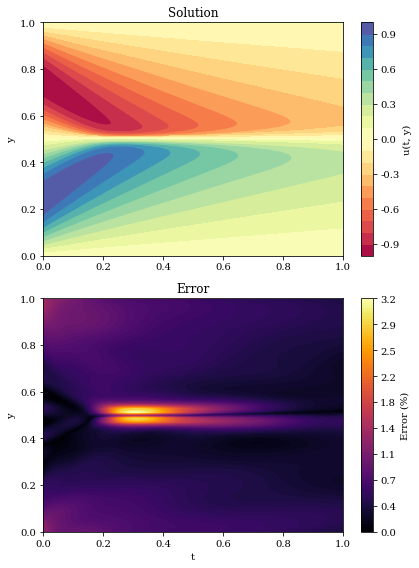

In [ ]:
ana_sol = fdm_sol
pinn_sol = net.forward(Xc, Yc)
error = torch.abs(pinn_sol - ana_sol) / torch.max(torch.abs(ana_sol)) * 100.0

import numpy.linalg as la
error_l2 = la.norm((pinn_sol - ana_sol).cpu().detach().numpy()) / np.sqrt(gridsize_x * gridsize_y)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

import matplotlib.ticker as ticker
# specify your own formatter for colorbar labels in return select desired format
def myfmt(x, pos):
    return '{0:.1f}'.format(x)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
cntr1 = ax1.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), cmap="Spectral", levels=20)
cbar1 = fig.colorbar(cntr1, ax=ax1, label='u(t, y)', format=ticker.FuncFormatter(myfmt))
# ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Solution')
# This is the fix for the white lines between contour levels
for c in cntr1.collections:
    c.set_edgecolor("face")

ax2 = plt.subplot(212)
cntr2 = ax2.contourf(*plot(X[:,:,0], Y[:,:,0], (error[:,:,0]) + 1e-12), cmap="inferno", levels=100)
cbar2 = fig.colorbar(cntr2, ax=ax2, label='Error (%)', format=ticker.FuncFormatter(myfmt))
ax2.set_xlabel('t')
ax2.set_ylabel('y')
ax2.set_title('Error')
for c in cntr2.collections:
    c.set_edgecolor("face")

plt.tight_layout()


In [ ]:
error_l2

0.006014337539672851

In [ ]:
fig.savefig('burgers_shock.eps', dpi=300)